In [4]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf,pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('AirPassengers.csv')

In [7]:
data['Month'].head()

0    1949-01
1    1949-02
2    1949-03
3    1949-04
4    1949-05
Name: Month, dtype: object

In [8]:
data['Month']=data['Month'].apply(lambda x:dt(int(x[:4]),int (x[5:]),15))
data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [9]:
ts = data['#Passengers']

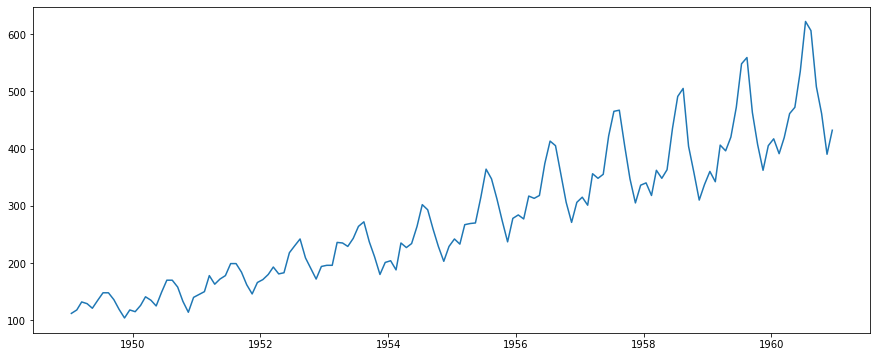

In [10]:
plt.plot(ts)

In [11]:
ts_log = np.log(ts)

In [12]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=52,center=False).mean()
    rolstd = timeseries.rolling(window=52,center=False).std()
    
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(rolmean,color='red',label='Rolling Mean')
    std = plt.plot(rolstd,color='black',label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used',
                                           'Number of Observations Used'])
    for key ,value in dftest[4].items():
        dfoutput['critical Value (%s)'%key] = value
    print(dfoutput)

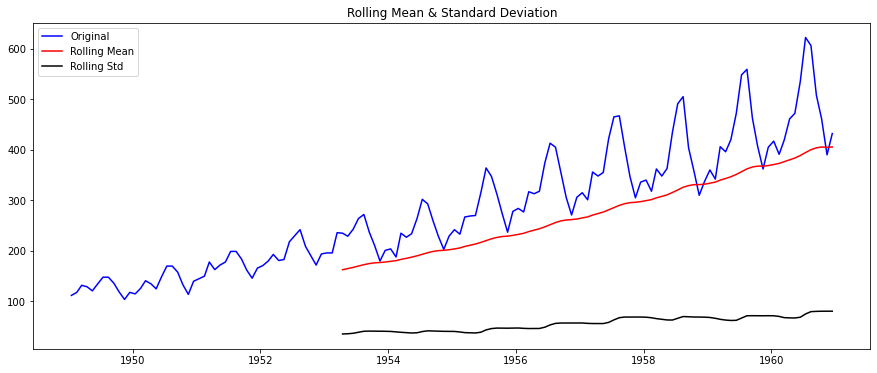

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
critical Value (1%)             -3.481682
critical Value (5%)             -2.884042
critical Value (10%)            -2.578770
dtype: float64


In [13]:
test_stationarity(data['#Passengers'])

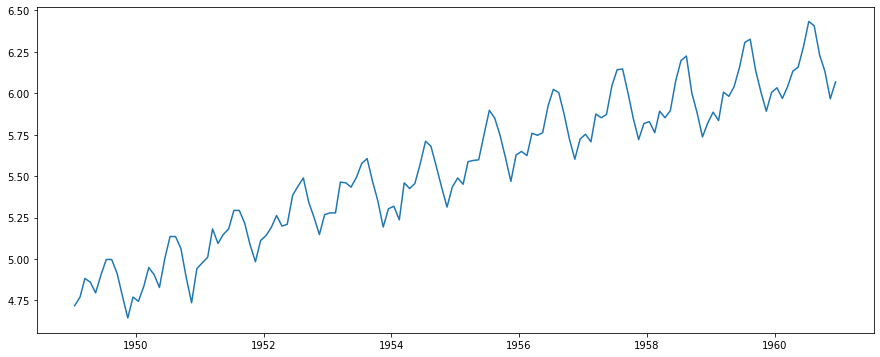

In [14]:
plt.plot(ts_log)

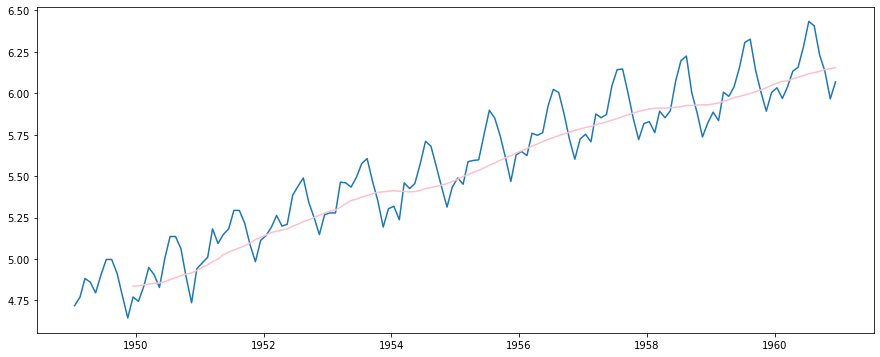

In [19]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage,color='pink')

In [20]:
ts_log_diff = ts_log - movingAverage
ts_log_diff.head(12)

ts_log_diff.dropna(inplace=True)
ts_log_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

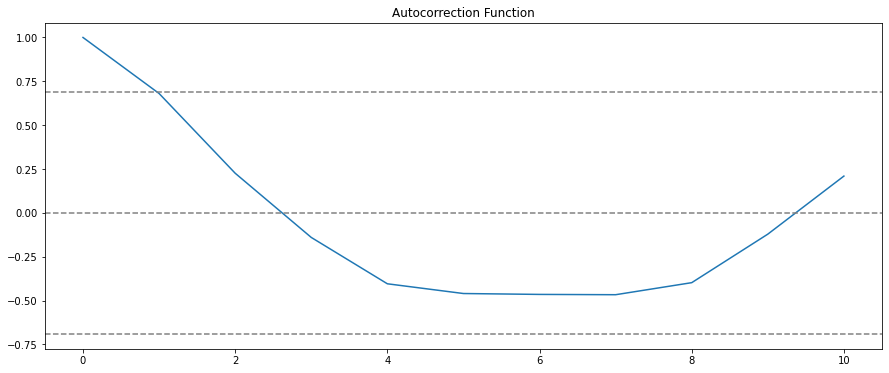

In [24]:
plt.plot(np.arange(0,11),acf(ts_log_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='grey')
plt.title('Autocorrection Function')
plt.show()

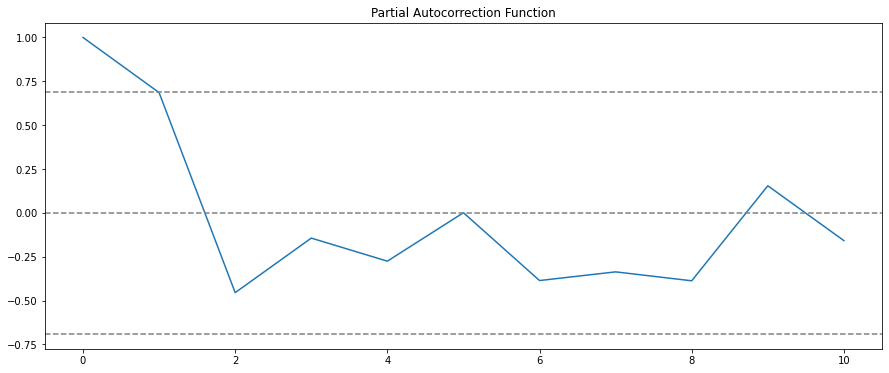

In [26]:
plt.plot(np.arange(0,11),pacf(ts_log_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='grey')
plt.title('Partial Autocorrection Function')
plt.show()

Text(0.5, 1.0, 'RSS:nan')

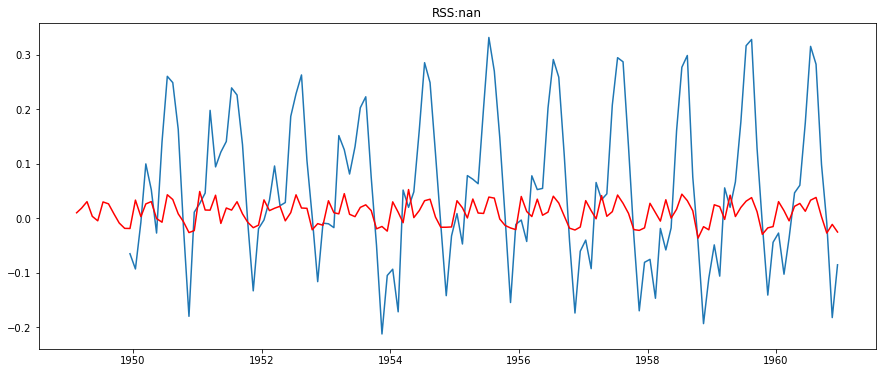

In [28]:
model = ARIMA(ts_log,order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS:%.4f'% sum((results_ARIMA.fittedvalues[1:]-ts_log_diff)**2))

In [31]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [32]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [34]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE:nan')

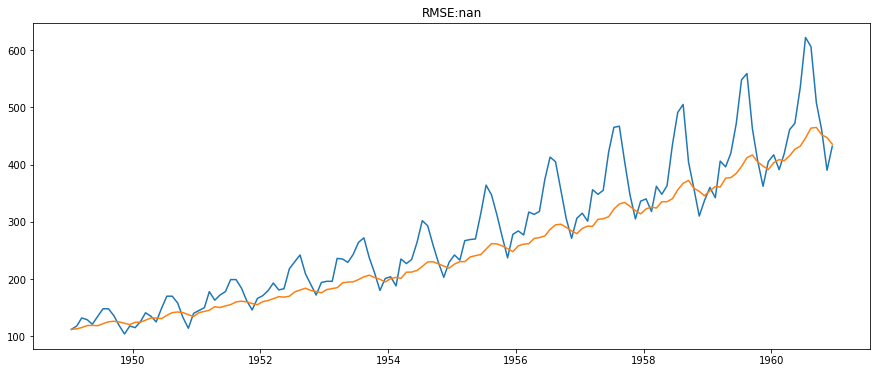

In [35]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE:%.4f'% np.sqrt(sum(predictions_ARIMA-ts**2)/len(ts)))